https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

In [2]:
#device = (
#    torch.device("mps") if torch.backends.mps.is_available()
#    else torch.device("cuda") if torch.cuda.is_available()
#    else torch.device("cpu")
#)  # Disable, MPS does not work with some operation at the moment
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

/home/maparla/anaconda3/envs/ml/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
model.eval()
model.to(device)
print("Model loaded")

Using cache found in /home/maparla/.cache/torch/hub/facebookresearch_dino_main


Model loaded


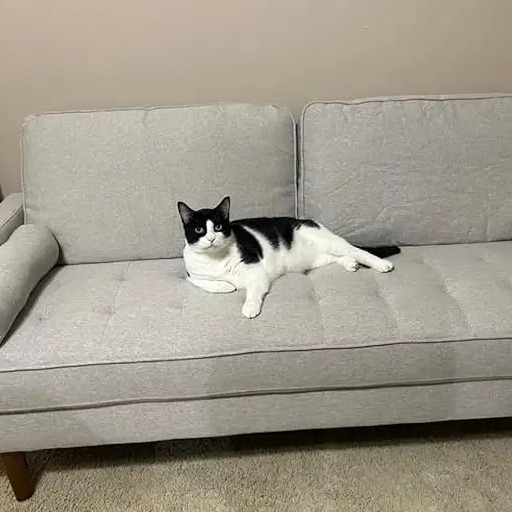

In [4]:
image_path = "cat.jpg"
with open(image_path, 'rb') as f:
    img = Image.open(f)
    img = img.convert('RGB')
img

In [5]:
image_size = (448, 448)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)

# make the image divisible by the patch size
patch_size = 8
w = img.shape[1] - img.shape[1] % patch_size
h = img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

# calculate the number of patches
ph = img.shape[2] // patch_size
pw = img.shape[3] // patch_size
print(f"Number of patches: {ph}x{pw} (={ph*pw})")

Number of patches: 56x56 (=3136)


In [6]:
with torch.no_grad():
    attentions = model.get_last_selfattention(img.to(device))
attentions.shape  # (batch, num_heads, num_patches+1, num_patches+1)

torch.Size([1, 6, 3137, 3137])

In [7]:
# we keep only the output patch attention
# We display the self-attention for [CLS] token query. 
attentions = attentions[0, :, 0, 1:]
attentions.shape  # (num_heads, num_patches-1) we discard the first token [CLS]
# so the the rows will not sum 1 anymore

torch.Size([6, 3136])

In [8]:
nh = attentions.shape[0] # number of heads

attentions = attentions.reshape(nh, pw, ph)
attentions.shape

torch.Size([6, 56, 56])

In [9]:
# need to unsqueeze to properly perform the interpolation
attentions = torch.nn.functional.interpolate(
    attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest"
)[0].cpu().numpy()

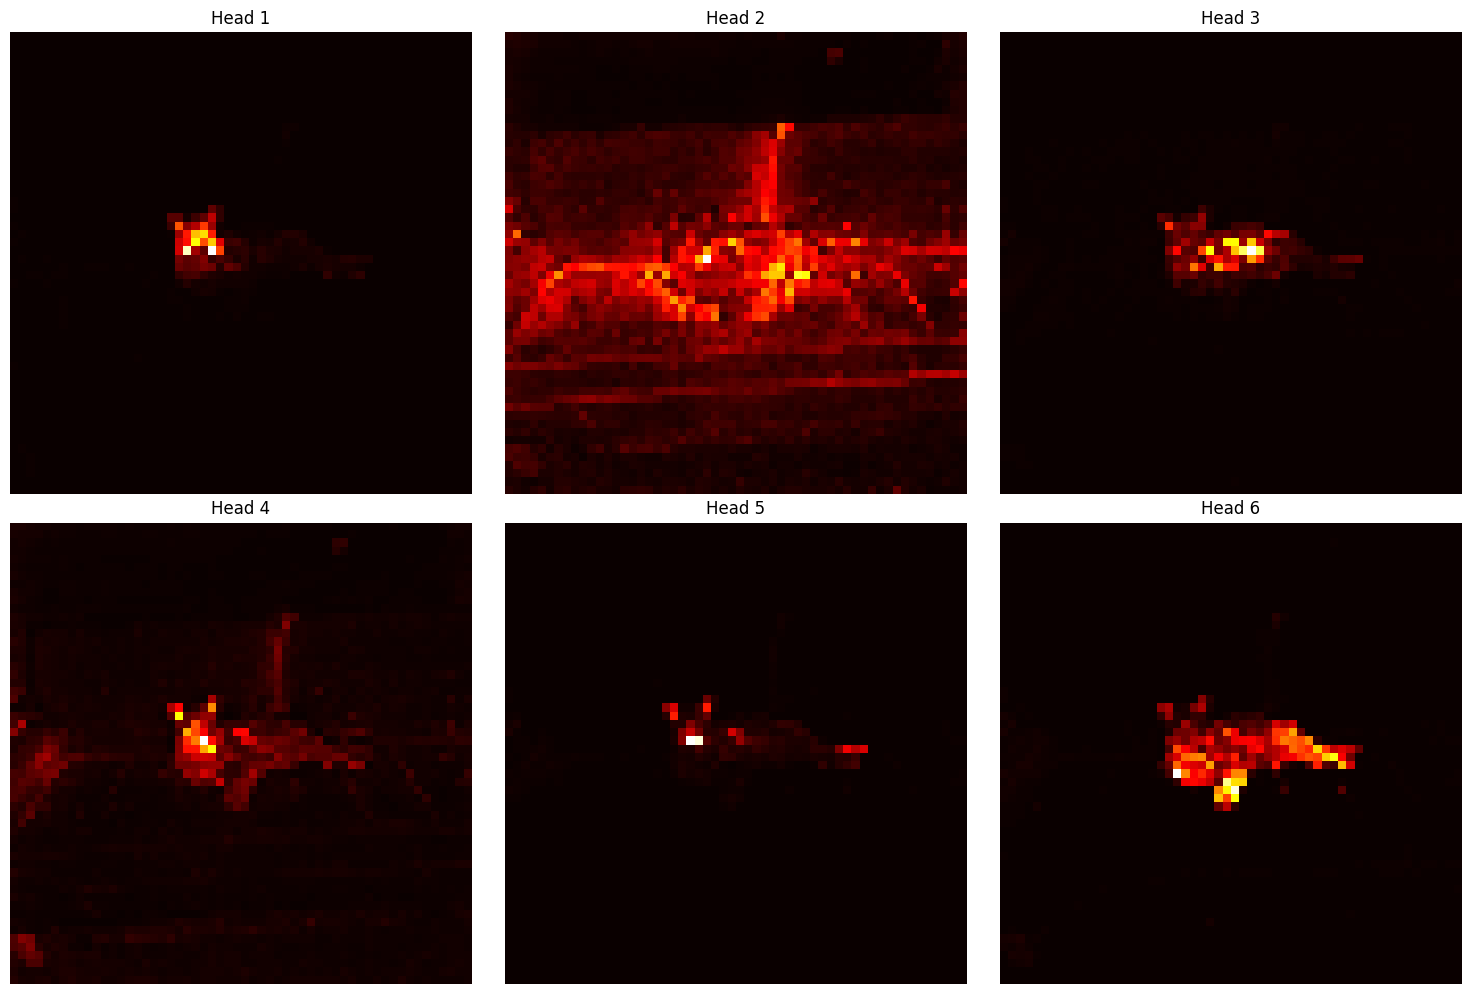

In [12]:
# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Plot each slice of the matrix
for i in range(6):
    im = axes[i].imshow(attentions[i], cmap="hot", interpolation="nearest")
    axes[i].set_title(f'Head {i+1}')
    axes[i].axis('off')  # Turn off axis labels

# Add a colorbar to the right of the subplots

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig("attention_map.png", dpi=300, transparent=True)
plt.show()